# Image Segmentation.

Name: Anthony Kevin Oktavius

Library Imports

In [ ]:
import numpy as np
import zipfile
import gc
import cv2
import math
import warnings
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
# import torchmetrics
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils

# import pytorch_lightning as pl
import imutils
import zipfile

from torch.utils.data import Dataset
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder
from torchvision.models.feature_extraction import create_feature_extractor
# from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Device Specifications:")
print(device_lib.list_local_devices())

Device Specifications:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1514908439166364011
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13825277952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5864873489686736324
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Preparation

Get Dataset

In [ ]:
! cp ./drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! kaggle datasets download -d bulentsiyah/semantic-drone-dataset

100% 3.88G/3.89G [00:54<00:00, 56.3MB/s]
100% 3.89G/3.89G [00:54<00:00, 76.5MB/s]


In [ ]:
! unzip -qq ./semantic-drone-dataset.zip -d ./Dataset

## Data Visualization

In [ ]:
labels_df = pd.read_csv("Dataset/class_dict_seg.csv")
labels_df

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [ ]:
print("Number of Labels:")
len(labels_df)

Number of Labels:


24

## Data Preprocessing

Perform Data Preprocessing to the images, these are the preprocessing steps:

*   Horizontal Flip
*   Vertical Flip
*   Brightness Adjustment
*   Saturation Value







In [ ]:
def transform_sample_image_dataset(image, brightness_value, saturation_value, crop_coordinate):
  # image = TF.crop(image, *crop_coordinate)
  # image = TF.adjust_brightness(image, brightness_value)
  # image = TF.adjust_saturation(image, saturation_value)
  # normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
  #                                             std=[0.229, 0.224, 0.225])
  # image = normalize_transform(image.float())
  return image

def transform_mapping_dataset(image, crop_coordinate):
  # image = TF.crop(image, *crop_coordinate)
  # one_hot_encoded = F.one_hot(image, num_classes = 24)
  # print(one_hot_encoded.shape)
  return image

class DroneSemanticSegmentationDataset(Dataset):
  """
  NOTE: The names that are used for image and mapping have to be the same.

  Example: 000.jpg for cat image and cat mapping image, 

  001.jpg for another cat and another cat mapping image.
  """

  def __init__(self, image_directory, mapping_directory, image_transform = None, mapping_transform = None):
    self.image_directory = image_directory
    self.mapping_directory = mapping_directory
    self.image_transform = image_transform
    self.mapping_transform = mapping_transform
    self.image_filenames = sorted(os.listdir(self.image_directory))
    self.mapping_filenames = sorted(os.listdir(self.mapping_directory))
    self._check_filename_length()

  def _check_filename_length(self):
    print(f"Number of item filenames: {len(self.image_filenames)}")
    print(f"Number of mapping filenames: {len(self.mapping_filenames)}")
    if len(self.image_filenames) != len(self.mapping_filenames):
      raise ValueError("Both item and mapping must have the same number of images!")

  def _get_random_squared_position(self, cropped_size = (400, 400)):
    MIN_TOP = 0
    MAX_TOP = 4000 - cropped_size[0] - 1
    MIN_LEFT = 0
    MAX_LEFT = 6000 - cropped_size[1] - 1

    top = random.randint(MIN_TOP, MAX_TOP)
    left = random.randint(MIN_LEFT, MAX_LEFT)

    return (top, left, cropped_size[0], cropped_size[1])

  def _crop_image(self, image, crop_coordinate):
    TOP = crop_coordinate[0]
    LEFT = crop_coordinate[1]
    WIDTH = crop_coordinate[2]
    HEIGHT = crop_coordinate[3]
    return image[TOP : TOP + HEIGHT, LEFT : LEFT + WIDTH]

  def __getitem__(self, index):

    is_vflip = random.randint(0, 1)
    is_hflip = random.randint(0, 1)
    brightness_value = random.uniform(0.8, 1.6)
    saturation_value = random.uniform(0.8, 1.6)

    item_name = self.image_filenames[index]
    mapping_name = self.mapping_filenames[index]

    item_path = f"{self.image_directory}/{item_name}"
    mapping_path = f"{self.mapping_directory}/{mapping_name}"
  
    item = cv2.imread(item_path)
    mapping = cv2.imread(mapping_path)
    mapping = cv2.cvtColor(mapping, cv2.COLOR_BGR2RGB)
    mapping = cv2.cvtColor(mapping, cv2.COLOR_RGB2GRAY)

    item = cv2.resize(item, (400, 400))
    mapping = cv2.resize(mapping, (400, 400))

    # random_crop_coordinate = self._get_random_squared_position()
    # item = self._crop_image(item, random_crop_coordinate)
    # mapping = self._crop_image(mapping, random_crop_coordinate)

    if is_vflip:
      item = cv2.flip(item, 0)
      mapping = cv2.flip(mapping, 0)

    if is_hflip:
      item = cv2.flip(item, 1)
      mapping = cv2.flip(mapping, 1)

    item = torch.from_numpy(item)
    mapping = torch.from_numpy(mapping)

    item = torch.reshape(item, (3, 400, 400))
    mapping = torch.reshape(mapping, (400, 400))

    if self.image_transform:
      item = self.image_transform(
        item,
        brightness_value,
        saturation_value,
        random_crop_coordinate
      )

    if self.mapping_transform:
      mapping = self.mapping_transform(
        mapping,
        random_crop_coordinate
      )
  
    return item, mapping
    
  def __len__(self):
    return len(self.image_filenames)

drone_semantic_segmentation_dataset = DroneSemanticSegmentationDataset(
  "./Dataset/dataset/semantic_drone_dataset/original_images",
  "./Dataset/dataset/semantic_drone_dataset/label_images_semantic",
  transform_sample_image_dataset,
  transform_mapping_dataset
)

max_iteration = 40
print(f"Sampling for {max_iteration} images")
for image_index, (sample_image, sample_mapping) in enumerate(drone_semantic_segmentation_dataset):
  print("==================================================")
  print(f"Sample Image size: {sample_image.shape}")
  print(f"Sample Mapping size: {sample_mapping.shape}")
  # print(sample_image)
  # print(sample_mapping)
  print("Mapping pixels Properties:")
  print(sample_mapping.min())
  print(sample_mapping.max())
  print("==================================================")
  if max_iteration == image_index:
    break

Number of item filenames: 400
Number of mapping filenames: 400
Sampling for 40 images
Sample Image size: torch.Size([3, 400, 400])
Sample Mapping size: torch.Size([400, 400])
Mapping pixels Properties:
tensor(1, dtype=torch.uint8)
tensor(1, dtype=torch.uint8)
Sample Image size: torch.Size([3, 400, 400])
Sample Mapping size: torch.Size([400, 400])
Mapping pixels Properties:
tensor(3, dtype=torch.uint8)
tensor(3, dtype=torch.uint8)
Sample Image size: torch.Size([3, 400, 400])
Sample Mapping size: torch.Size([400, 400])
Mapping pixels Properties:
tensor(3, dtype=torch.uint8)
tensor(3, dtype=torch.uint8)
Sample Image size: torch.Size([3, 400, 400])
Sample Mapping size: torch.Size([400, 400])
Mapping pixels Properties:
tensor(0, dtype=torch.uint8)
tensor(18, dtype=torch.uint8)
Sample Image size: torch.Size([3, 400, 400])
Sample Mapping size: torch.Size([400, 400])
Mapping pixels Properties:
tensor(1, dtype=torch.uint8)
tensor(17, dtype=torch.uint8)
Sample Image size: torch.Size([3, 400, 400

See the data visualization of our data.

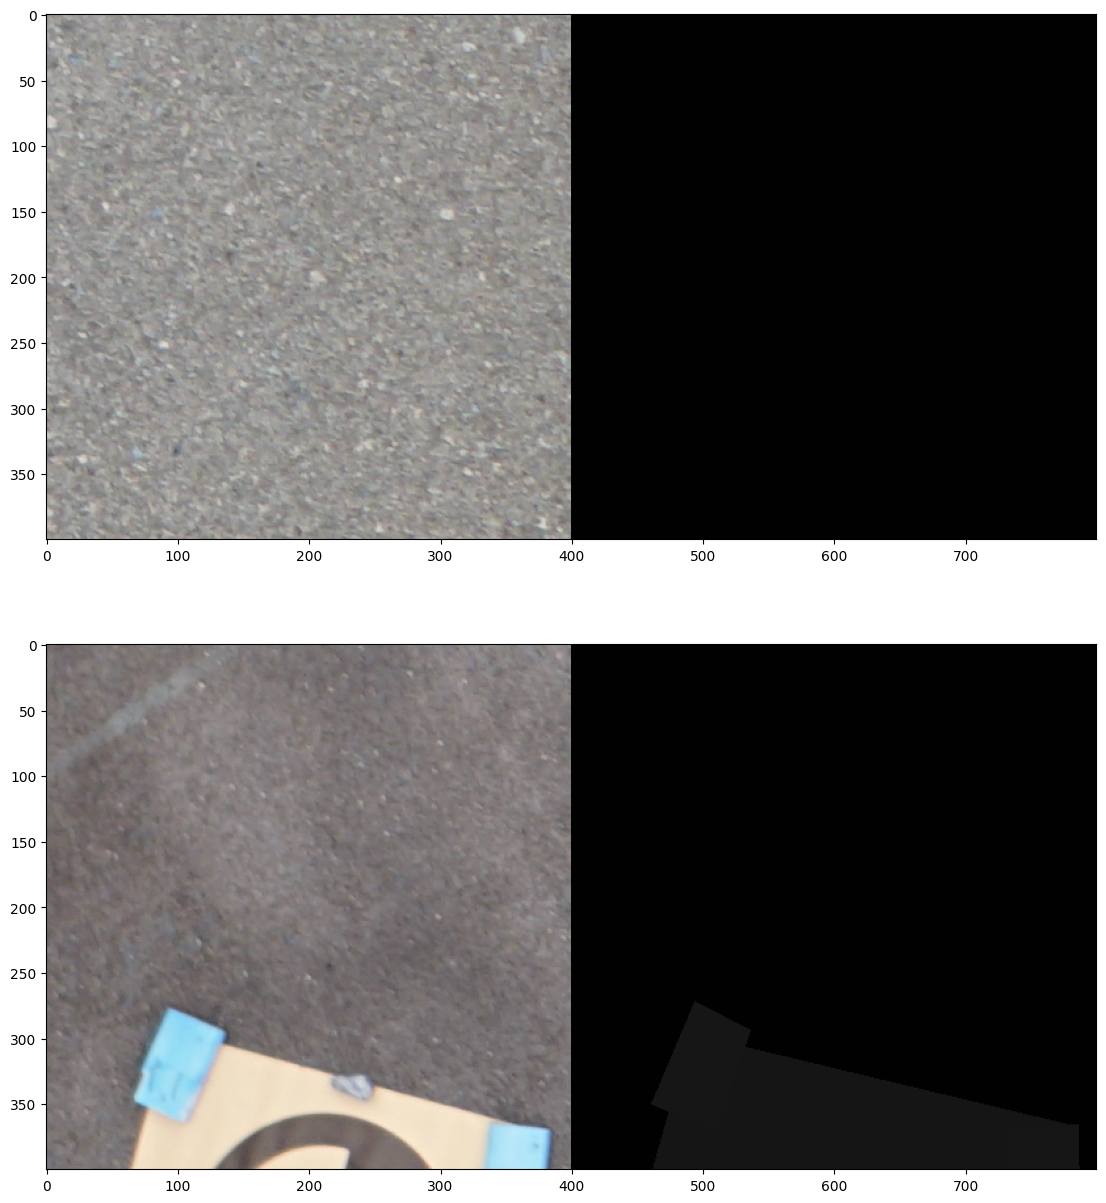

In [ ]:
N_ROWS = 2
N_COLS = 1
fig, axes = plt.subplots(nrows = N_ROWS, ncols = N_COLS, figsize = (15, 15))

def pairwise_visualization(sample_image, label_image, ax):
  """
  Note that this function only works with one single sample image and
  label image!
  """
  sample_image_vis = torch.reshape(sample_image, (400, 400, 3)).numpy()
  label_image_vis = torch.reshape(label_image, (400, 400)).numpy() 
  label_image_vis = cv2.cvtColor(label_image_vis, cv2.COLOR_GRAY2RGB)
  label_image_vis = np.reshape(label_image_vis, (400, 400, 3))
  pairwise_image = np.hstack((sample_image_vis, label_image_vis))
  ax.imshow(pairwise_image,)
  # plt.axis("off")

drone_iter = iter(drone_semantic_segmentation_dataset)

for row_index in range(0, N_ROWS):
  # for row_column in (0, N_COLS - 1):
    sample_image, sample_mapping = next(drone_iter)
    pairwise_visualization(sample_image, sample_mapping, axes[row_index])

## Data Modelling

U Net Data Modelling with Pretrained Model. We use VGG16 Net Model.

Original model can be found from this link:
https://arxiv.org/pdf/1505.04597v1.pdf


In [ ]:
def print_whole_model(model):
  print(list(model.modules()))

vgg16_model = models.vgg16(pretrained = True)
print_whole_model(vgg16_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 228MB/s]


[VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

See Each of Pretrained Models' Layers

In [ ]:
def flatten_layers_from_model(model, START_FROM_INDEX = 1):
  # Get all the model layers, except Sequential Layers, 
  # since we'd like to iterate the layers one by one.
  model_layers = list(model.modules())[START_FROM_INDEX:]
  flattened_model_layers = []

  # Filter layers, as we don't want to process sequential layers.
  for index, layer in enumerate(model_layers):
    if type(layer) != torch.nn.modules.container.Sequential:
      flattened_model_layers.append(layer)

  return flattened_model_layers

def inspect_model(model):

  print("==========================================================")
  print("Layer Names:")
  non_sequential_layers =  flatten_layers_from_model(model)
  for index, layer in enumerate(non_sequential_layers):
    print(f"{index}: {layer}")
  print("==========================================================")

  print("==========================================================")
  print("Model Weights: ")
  model_weights = model.state_dict()
  layer_names = model_weights.keys()
  for layer_name in layer_names:
    print(f"{layer_name}: {model_weights[layer_name].shape}")
  print("==========================================================")
  
inspect_model(vgg16_model)

Layer Names:
0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1: ReLU(inplace=True)
2: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3: ReLU(inplace=True)
4: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6: ReLU(inplace=True)
7: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8: ReLU(inplace=True)
9: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11: ReLU(inplace=True)
12: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13: ReLU(inplace=True)
14: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15: ReLU(inplace=True)
16: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
17: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18: ReLU(inplace=True)
19: Co

In case you need a refresher, here's the architecture of the U-Net model.

![U-Net Model](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png)

In [ ]:
class VGG16_UNET_Model(nn.Module):
  def __init__(self):
    super(VGG16_UNET_Model, self).__init__()

    vgg16_model = models.vgg16(pretrained = True)
    vgg16_model.eval()
    # Freeze vgg16_model layers
    for param in vgg16_model.parameters():
      param.requires_grad = False
    
    flattened_vgg16_model = flatten_layers_from_model(vgg16_model, 1)

    ####################################################################
    # DOWNSAMPLING SEQUENTIAL LAYERS
    ####################################################################
    # The first 3 top left from U-Net architecture from the image above.
    self.first_part_downsample_layer = nn.Sequential(
        flattened_vgg16_model[0],
        flattened_vgg16_model[1],
        flattened_vgg16_model[2],
        flattened_vgg16_model[3],
        flattened_vgg16_model[4],
    )

    self.second_part_downsample_layer = nn.Sequential(
        flattened_vgg16_model[5],
        flattened_vgg16_model[6],
        flattened_vgg16_model[7],
        flattened_vgg16_model[8],
        flattened_vgg16_model[9],
    )

    self.third_part_downsample_layer = nn.Sequential(
        flattened_vgg16_model[10],
        flattened_vgg16_model[11],
        flattened_vgg16_model[12],
        flattened_vgg16_model[13],
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    )
  
    ####################################################################
    ####################################################################
    # UPSAMPLING SEQUENTIAL LAYERS
    ####################################################################
    self.middle_part_layer = nn.Sequential(
      nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      # nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    )

    self.first_part_upsample_layer = nn.Sequential(
      nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.Upsample(scale_factor = 2),
    )

    self.second_part_upsample_layer = nn.Sequential(
      nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.Upsample(scale_factor = 2),
    )
    
    self.third_part_upsample_layer = nn.Sequential(
      nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(),
      nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.Upsample(scale_factor = 2),
      nn.Conv2d(32, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    )

    # self.output_layer = nn.Sequential(
    #     nn.LogSoftmax(dim = 0)
    # )

    # self.output_layer = nn.Sequential(
    #   nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    #   nn.ReLU(),
    #   nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    #   nn.ReLU(),
    #   nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    # )

  def forward(self, x):
    CONCAT_FILTERS_DIM_IN_INT = 1 # Concat based on the number of filters.
    ####################################################################
    # FEEDFORWARD DOWNSAMPLING LAYERS
    ####################################################################
    x = self.first_part_downsample_layer(x.float())
    # print(f"First downsample layer debug: {x.shape}")
    x_from_first_part_layer = x.detach()
    
    x = self.second_part_downsample_layer(x)
    # print(f"Second downsample layer Debug: {x.shape}")
    x_from_second_part_layer = x.detach()

    x = self.third_part_downsample_layer(x)
    # print(f"Third downsample layer debug: {x.shape}")
    x_from_third_part_layer = x.detach()

    x = self.middle_part_layer(x)
    # print(f"Middle upsample layer debug: {x.shape}")
    x = torch.cat([x, x_from_third_part_layer], CONCAT_FILTERS_DIM_IN_INT)
    # print(f"Fourth layer debug (concatted): {x.shape}")

    ####################################################################
    # FEEDFORWARD UPSAMPLING LAYERS
    ####################################################################
    x = self.first_part_upsample_layer(x)
    # print(f"Fourth layer debug: {x.shape}")
    x = torch.cat([x, x_from_second_part_layer], CONCAT_FILTERS_DIM_IN_INT)
    # print(f"Fifth layer debug (concatted): {x.shape}")

    x = self.second_part_upsample_layer(x)
    # print(f"Fifth layer debug: {x.shape}")
    x = torch.cat([x, x_from_first_part_layer], CONCAT_FILTERS_DIM_IN_INT)
    # print(f"Middle layer debug (concatted): {x.shape}")
  
    x = self.third_part_upsample_layer(x)
    # print(f"Sixth layer debug: {x.shape}")

    # x = self.output_layer(x)
  
    # x = self.output_layer(x)
    # print(f"Final Layer debug: {x.shape}")

    return x

print(VGG16_UNET_Model())

VGG16_UNET_Model(
  (first_part_downsample_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (second_part_downsample_layer): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (third_part_downsample_layer): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, pa

Make Data Loaders from the Dataset Class.

In [ ]:
TRAIN_SIZE = 350
VAL_SIZE = 50
drone_segmentation_train, drone_segmentation_val = torch.utils.data.random_split(
    drone_semantic_segmentation_dataset,
    [TRAIN_SIZE, VAL_SIZE]
)

print(f"Drone segmentation train size: {len(drone_segmentation_train)}")
print(f"Drone segmentation val size: {len(drone_segmentation_val)}")

drone_segmentation_train_dataloader = torch.utils.data.DataLoader(
  drone_segmentation_train,
  batch_size = 8,
  shuffle = True,
)

drone_segmentation_val_dataloader = torch.utils.data.DataLoader(
  drone_segmentation_val,
  batch_size = 8,
  shuffle = True,
)

print()
print('Debugging train loader...')
for sample_image, sample_mapping in drone_segmentation_train_dataloader:
  print(sample_image.shape)
  print(sample_mapping.shape)
  break
  
print()
print('Debugging validation loader...')
for sample_image, sample_mapping in drone_segmentation_val_dataloader:
  print(sample_image.shape)
  print(sample_mapping.shape)
  break

Drone segmentation train size: 350
Drone segmentation val size: 50

Debugging train loader...
torch.Size([8, 3, 400, 400])
torch.Size([8, 400, 400])

Debugging validation loader...
torch.Size([8, 3, 400, 400])
torch.Size([8, 400, 400])


RUN THIS IF YOU HAVE A TRAINED MODEL.

In [ ]:
def load_model(model, optimizer, filename = "model.pth.tar"):
  print("Loading model...")
  checkpoint = torch.load(filename)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print("Finished loading model!")

  return model, optimizer

device_name = "GPU"
directory_path = "./drive/MyDrive"
vgg16_unet_model = VGG16_UNET_Model()
vgg16_unet_model.to(device)
cross_entropy_loss_function = nn.CrossEntropyLoss()
adam_optimizer = optim.Adam(vgg16_unet_model.parameters(), lr = 0.001)
ocr_tmnist_model, adam_optimizer = load_model(vgg16_unet_model, adam_optimizer, f"{directory_path}/model.pth.tar")

Loading model...
Finished loading model!


RUN THIS IF YOU HAVEN'T HAD ANY TRAINED MODEL YET.

In [ ]:
vgg16_unet_model = VGG16_UNET_Model()
vgg16_unet_model.to(device)

# We use reduction = None to get the loss by each pixel.
adam_optimizer = optim.Adam(vgg16_unet_model.parameters(), lr = 0.001)

Create a Loss for balancing loss between each classes.

In [ ]:
loss_weights_for_each_classes = [1, 1] # The first 2 categories are dominant compared to other ones.
loss_weights_for_each_classes = loss_weights_for_each_classes + ([8] * 22) # The rest of the classes are prioritized.
print(loss_weights_for_each_classes)
for index, loss_weight in enumerate(loss_weights_for_each_classes):
  loss_weights_for_each_classes[index] = loss_weight / 24

loss_weights_for_each_classes = torch.FloatTensor(loss_weights_for_each_classes).to(device)
print(loss_weights_for_each_classes)
print(len(loss_weights_for_each_classes))

[1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
tensor([0.0417, 0.0417, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
        0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
        0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333], device='cuda:0')
24


In [ ]:
class ImageSegmentationLoss(nn.Module):
  def __init__(self, labels, loss_weights):
    super(ImageSegmentationLoss, self).__init__()
    self.labels = labels
    self.loss_weights = loss_weights

  def forward(self, outputs):
    # flattened_outputs = outputs.reshape(-1)
    # flattened_labels = self.labels.reshape(-1)

    # loss_func = nn.CrossEntropyLoss()
    # loss_values = F.cross_entropy(flattened_outputs, flattened_labels)
    loss_values = F.cross_entropy(outputs, self.labels, weight = self.loss_weights)
    return loss_values

Perform Model Training and Validation

In [ ]:
def training_step(model, optimizer, train_batch, device):
  data, labels = train_batch
  data = data.float()
  labels = labels.long()
  data = data.to(device)
  labels = labels.to(device)

  optimizer.zero_grad()

  outputs = model(data)

  # outputs = torch.argmax(outputs, axis = 1)

  loss_func = ImageSegmentationLoss(labels, loss_weights_for_each_classes)
  loss = loss_func(outputs)
  loss.backward()
  optimizer.step()

  return loss.item()

def validate_model(model, val_batches, device):
  with torch.no_grad():
    correct = 0
    total = 0
    for batch in val_batches:
      data, labels = batch

      # Move the data to GPU.
      data = data.to(device)  
      labels = labels.to(device)

      # Perform feed forward to the model.
      outputs = model(data)

      # Get the prediction of each output. (Softmax)
      predicted = torch.argmax(outputs.data, 1)

      # print(predicted.shape)
      # print(outputs.shape)

      # Get the label size to total variable. 
      total += labels.size(0)

      # Determine the number of pixels.
      total_number_of_pixels = labels.size(2) ** 2
 
      # Keep a running total.
      correct += (predicted == labels).sum().item()
      correct /= total_number_of_pixels

    accuracy = 100 * correct / total
    return accuracy

def save_model(model, optimizer, filename = "model.pth.tar"):
  print("Saving model...")
  checkpoint = {
      "model_state_dict": model.state_dict(),
      "optimizer_state_dict": optimizer.state_dict()
  }
  torch.save(checkpoint, filename)
  print("Finished saving model!")

def train_model(epochs, model, train_loader, validation_loader, optimizer, device, num_validation_per_steps = 200):
  print("Start training...")
  print(f"Train loader size: {len(train_loader)}")
  print(f"Validation loader size: {len(validation_loader)}")
  for epoch in range(epochs):
    running_loss = 0.0
    total_iteration = 0

    for iteration, batch in enumerate(train_loader):
      # Perform training and get the current batch loss
      
      current_batch_loss = training_step(model, optimizer, batch, device)
      # Add the current batch loss to running loss.
      running_loss += current_batch_loss
      total_iteration += 1

    running_loss /= total_iteration

    # Validate after every epoch.
    
    validation_accuracy = validate_model(model, validation_loader, device)
    
    print(f"Epoch: [{epoch + 1}/{epochs}], Training Loss: {running_loss}, Validation Accuracy: {validation_accuracy}")
    save_model(model, optimizer, "drive/MyDrive/new_semantic_segmentation_model.pth.tar")
    running_loss = 0.0

train_model(
  epochs = 100,
  model = vgg16_unet_model,
  train_loader = drone_segmentation_train_dataloader,
  validation_loader = drone_segmentation_val_dataloader,
  optimizer = adam_optimizer,
  device = device,
)

Start training...
Train loader size: 44
Validation loader size: 7
Epoch: [1/100], Training Loss: 5.496634943918749, Validation Accuracy: 0.11672505339744145
Saving model...
Finished saving model!
Epoch: [2/100], Training Loss: 2.6280223402110012, Validation Accuracy: 1.868033837981541
Saving model...
Finished saving model!
Epoch: [3/100], Training Loss: 2.506068153814836, Validation Accuracy: 3.874562498230583e-05
Saving model...
Finished saving model!
Epoch: [4/100], Training Loss: 2.4926368214867334, Validation Accuracy: 2.5107195147959345e-05
Saving model...
Finished saving model!
Epoch: [5/100], Training Loss: 2.4060703705657613, Validation Accuracy: 0.010824979276167157
Saving model...
Finished saving model!
Epoch: [6/100], Training Loss: 2.3826286142522637, Validation Accuracy: 0.4892933787745796
Saving model...
Finished saving model!
Epoch: [7/100], Training Loss: 2.4204083789478648, Validation Accuracy: 4.075125068395792e-05
Saving model...
Finished saving model!
Epoch: [8/100]

KeyboardInterrupt: ignored

Visualize the Result

In [ ]:
def plot_result(latent_vector, decoder_1, decoder_2):
  pass

  